## Project: Thermodynamical Properties

### Import Library

In [1]:
import numpy as np
import sympy as sp
#from numba import int32, int64, float32, float64, vectorize

import os
from mpi4py import MPI
from numba import njit

import matplotlib.pyplot as plt
from plotly import graph_objs as go
from plotly import express as px
from IPython.display import Image

import time
import timeit
from threading import Thread
from multiprocessing import Pool, Process
from scipy.integrate import quad

import warnings
warnings.filterwarnings('ignore')

### Functions

In [2]:
%%writefile custom_functions.py
import numpy as np
from numba import njit

def trapezoidal_function(f, xmin: int, xmax: float, n: int, **kwargs):
    integral = 0.0
    dx = (xmax - xmin) / (n+1)

    for x in np.linspace(xmin, xmax, n):
        integral += dx * ( f(x, **kwargs) + f(x+dx, **kwargs) )/2

    return integral

def func(x):
    return (1 - x**2)**0.5

def phonon_dos(omega, omega_c=10, C=1):
    return C * omega**2 * np.exp(-omega / omega_c)

def entropy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return (x / np.tanh(x / 2) - np.log(2 * np.sinh(x / 2))) * phonon_dos(omega)

@njit
def jit_entropy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return (x / np.tanh(x / 2) - np.log(2 * np.sinh(x / 2))) * 1 * omega**2 * np.exp(-omega / 10)

def phonon_dos(omega, omega_c=10, C=1):
    return C * omega**2 * np.exp(-omega / omega_c)

def enthalpy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return hbar*omega * (1 / np.tanh(x / 2)) * phonon_dos(omega)

@njit
def jit_enthalpy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return hbar*omega * (1 / np.tanh(x / 2)) * 1 * omega**2 * np.exp(-omega / 10)

Overwriting custom_functions.py


In [3]:
import custom_functions as custom_f

### Constants

In [4]:
hbar = 1.054e-34
kB = 1.38e-23
custom_f.trapezoidal_function(
    f=custom_f.func,
    xmin=-0.99,
    xmax=0.99,
    n=10000,
)

1.5686275328175605

### Task 1: Enthropy

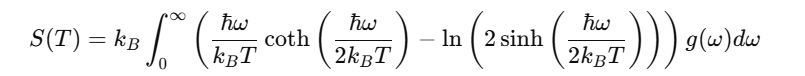

In [6]:
omega_min, omega_max = 1, 1000
n = 10000
T=273
array_size = np.arange(10**6, 10**7+1, 10**6)
enthropy_time = np.zeros(len(array_size))
paral_enthropy_time = np.zeros(len(array_size))

In [7]:
entropy_value = kB * custom_f.trapezoidal_function(
    f=custom_f.entropy,
    xmin=omega_min,
    xmax=omega_max,
    n=n,
    T=T,
    kb=kB,
    hbar=hbar)
entropy_value

8.271947235011321e-19

In [8]:
def paral_trapezoidal_function(params):
    xmin, xmax, n, T, kb, hbar = params
    integral = 0.0
    dx = (xmax - xmin) / (n+1)
    
    for omega in np.linspace(xmin, xmax, n):
        x = hbar*omega / (kb*T)
        f_x = (x / np.tanh(x / 2) - np.log(2 * np.sinh(x / 2))) * 1 * omega**2 * np.exp(-omega / 10)
        f_dx = ((x+dx) / np.tanh((x+dx) / 2) - np.log(2 * np.sinh((x+dx)/ 2))) * 1 * omega**2 * np.exp(-omega / 10)
        integral += dx * (f_x + f_dx)/2

    return integral

In [ ]:
def f(x):
    return x*x

with Pool(5) as p:
    print(p.map(f, [1, 2, 3]))

In [10]:
num_intervals = 2
chunk_size = 1000 / num_intervals

intervals = [(i * chunk_size, (i + 1) * chunk_size, n//num_intervals, T, kB, hbar) for i in range(num_intervals)]

# with Pool(processes=num_intervals) as pool:
#     results = pool.map(func=paral_trapezoidal_function, iterable=intervals)

In [ ]:
try:
    with Pool(processes=num_intervals) as pool:
        results = pool.map(func=paral_trapezoidal_function, iterable=intervals)
except Exception as e:
    print(f"Error during parallel computation: {e}")

In [12]:
%%writefile parallel_entropy.py

# Import Library
from mpi4py import MPI
import numpy as np
import argparse
import custom_functions as custom_f

# Constants
hbar = 1.054e-34
kB = 1.38e-23

# Parser
parser = argparse.ArgumentParser()
parser.add_argument('--xmin', type=float, help='Lower bound of the integral')
parser.add_argument('--xmax', type=float, help='Upper bound of the integral')
parser.add_argument('--n', type=int, help='Number of points in the integral')
parser.add_argument('--T', type=int, help='Temperature')
args = parser.parse_args()
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Chunk range
N = args.xmax - args.xmin
chunk_size = N // size

start = args.xmin + rank*chunk_size
end = start + chunk_size if rank != size - 1 else args.xmax

global_integral = None
if rank == 0:
    global_integral = np.array([0], dtype=np.float64)

# Main Calculations
entropy_value = kB * custom_f.trapezoidal_function(
    f=custom_f.entropy,
    xmin=start,
    xmax=end,
    n=args.n,
    T=args.T,
    kb=kB,
    hbar=hbar)

comm.Reduce(np.array(entropy_value), global_integral, op=MPI.SUM, root=0)

# Output results
if rank == 0:
    print(f"Entropy: {global_integral[0]}")

Overwriting parallel_entropy.py


In [14]:
!mpiexec -n 2 python parallel_entropy.py --xmin={omega_min} --xmax={omega_max} --n={n} --T=273

Entropy: 8.273591647184507e-19


### Task 2: Enthalpy

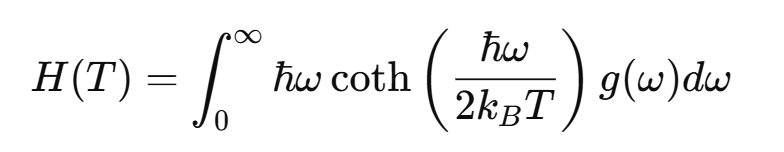

#### Values

In [7]:
omega_min, omega_max = 1, 1000
T=273
array_size = np.arange(10**6, 10**7+1, 10**6)
enthalpy_time = np.zeros(len(array_size))
paral_enthalpy_time = np.zeros(len(array_size))

#### Regular & Numba Implementation

In [8]:
for i, N in enumerate(array_size):
    enthalpy_time[i] = timeit.timeit(lambda: custom_f.trapezoidal_function(
    f=custom_f.enthalpy,
    xmin=omega_min,
    xmax=omega_max,
    n=N,
    T=T,
    kb=kB,
    hbar=hbar
    ), number=1)

    paral_enthalpy_time[i] = timeit.timeit(lambda: custom_f.trapezoidal_function(
        f=custom_f.jit_enthalpy,
        xmin=omega_min,
        xmax=omega_max,
        n=N,
        T=T,
        kb=kB,
        hbar=hbar,
    ), number=1)

#### Performance

In [140]:
fig = go.Figure()

fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, np.arange(1, 11, 1))),
                            y = enthalpy_time,
                            name = 'Regular',
                            ))
fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, np.arange(1, 11, 1))),
                            y = paral_enthalpy_time,
                            name = 'Numba',
                            ))

fig.update_layout(font_size = 25,
                    font_color='black',
                    title = "Evaluation",
                    plot_bgcolor = 'rgba(250,250,250,1)',
                    width = 1400,
                    height = 700,
                    # LEGEND
                    legend_title = "Models",
                    legend_font_size = 25,
                    legend_x = 1.02,
                    legend_y = 1,
                    #legend_bordercolor = 'black',
                    #legend_borderwidth = 1,
                    legend_itemsizing = 'trace',
                    legend_itemwidth=100,
                    # X-axis
                    xaxis_title = f"Size of arrays, 10<sup>6</sup>",
                    #xaxis_nticks = 7,
                    xaxis_ticklen = 16,
                    xaxis_tickwidth = 3,
                    xaxis_ticks = 'outside',
                    # Y-axis
                    yaxis_title = "Computation time, s",
                    #yaxis_nticks = 10,
                    yaxis_ticklen = 16,
                    yaxis_tickwidth = 3,
                    yaxis_ticks = 'outside'
                    )

fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
        line=dict(
            color="black",
                width=1,))
fig.layout.font.family = 'sans-serif'
fig.write_image(file="Project_images/Enthalpy_evaluation.png",
                format='png',
                width=1400,
                height=700,
                scale=1
                )
#fig.show()

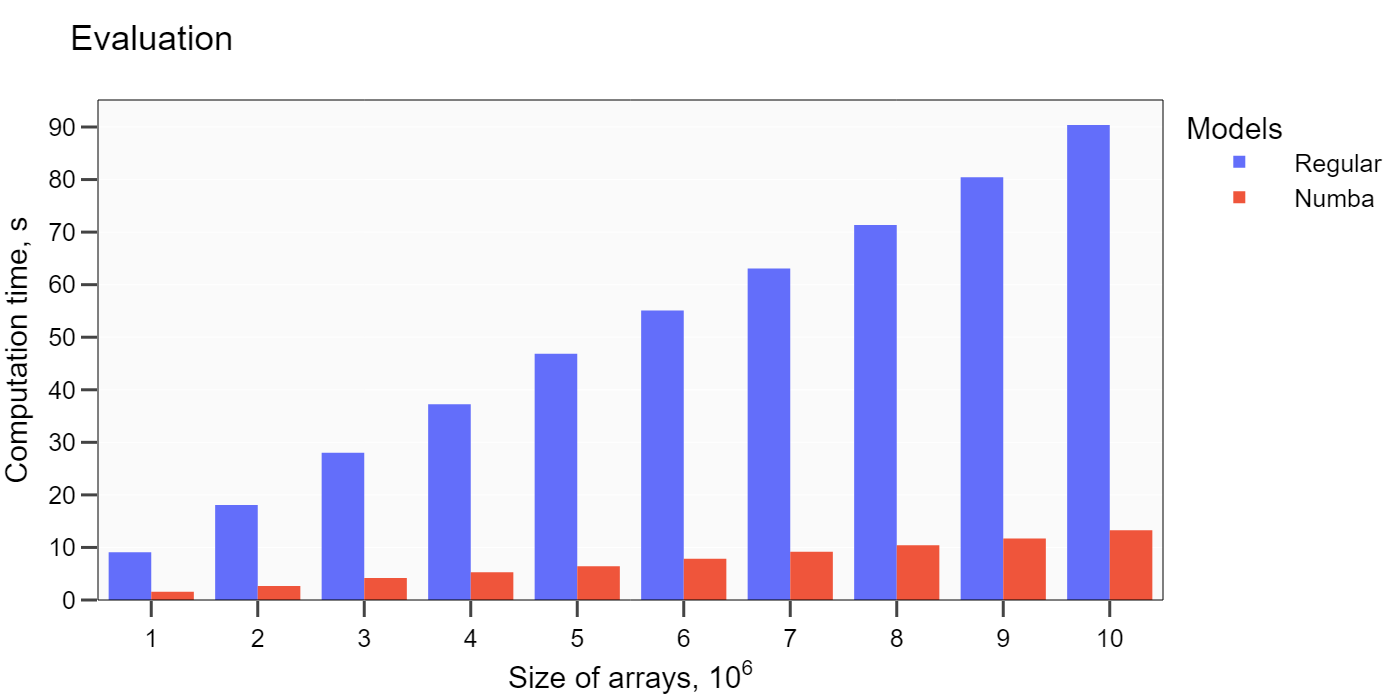

In [141]:
Image(open("Project_images/Enthalpy_evaluation.png", 'rb').read())


### Task 3: Gibbs Energy

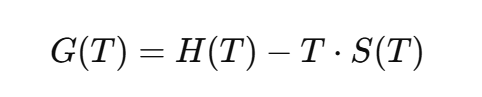

#### Values

In [131]:
omega_min, omega_max = 1, 1000
n = 100000
T=100
tmin, tmax, step = 100, 1001, 5
step_array = np.arange(5, 51, 5)
gibbsEnergy_time = np.zeros_like(step_array)
paral_gibbsEnergy_time = np.zeros_like(step_array)

#### Regular Implementation

In [132]:
for i, step in enumerate(step_array):
    temp_range = np.arange(tmin, tmax, step)
    #gibbs_energy = np.zeros_like(temp_range, dtype=np.float64)

    start_time = time.time()
    for j, T in enumerate(temp_range):
        entropy_value = - T * kB * custom_f.trapezoidal_function(
            f=custom_f.jit_entropy,
            xmin=omega_min,
            xmax=omega_max,
            n=n,
            T=T,
            kb=kB,
            hbar=hbar)

        enthalpy_value = custom_f.trapezoidal_function(
            f=custom_f.jit_enthalpy,
            xmin=omega_min,
            xmax=omega_max,
            n=n,
            T=T,
            kb=kB,
            hbar=hbar
            )
    end_time = time.time()
    gibbsEnergy_time[i] = end_time - start_time
    #gibbs_energy[j] = enthalpy_value + entropy_value

#### MPI Implementation

In [134]:
%%writefile parallel_gibbs_energy.py

# Import Library
from mpi4py import MPI
import numpy as np
import argparse
import custom_functions as custom_f

# Constants
hbar = 1.054e-34
kB = 1.38e-23

# Parser
parser = argparse.ArgumentParser()
parser.add_argument('--tmin', type=int, help='Lower bound of the temperature')
parser.add_argument('--tmax', type=int, help='Upper bound of the temperature')
parser.add_argument('--step', type=int, help='Temperature step')
parser.add_argument('--xmin', type=float, help='Lower bound of the integral')
parser.add_argument('--xmax', type=float, help='Upper bound of the integral')
parser.add_argument('--n', type=int, help='Number of points in the integral')
args = parser.parse_args()
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

temp_range = np.arange(args.tmin, args.tmax, args.step)
local_values = np.zeros_like(temp_range, dtype=np.float64)
global_values = None
if rank == 0:
    global_values = np.zeros_like(temp_range, dtype=np.float64)

# Main Calculations
for i, T in enumerate(temp_range):
    if rank == 0:
        local_values[i] = - T * kB * custom_f.trapezoidal_function(
            f=custom_f.jit_entropy,
            xmin=args.xmin,
            xmax=args.xmax,
            n=args.n,
            T=T,
            kb=kB,
            hbar=hbar)
    else:
        local_values[i] = custom_f.trapezoidal_function(
            f=custom_f.jit_enthalpy,
            xmin=args.xmin,
            xmax=args.xmax,
            n=args.n,
            T=T,
            kb=kB,
            hbar=hbar
            )
    
comm.Reduce(local_values, global_values, op=MPI.SUM, root=0)

# Output results
# if rank == 0:
#     print(f"Gibbs Free Energy: {global_values}")

Overwriting parallel_gibbs_energy.py


In [135]:
for i, step in enumerate(step_array):
    start_time = time.time()
    os.system(f'mpiexec -n 2 python parallel_gibbs_energy.py --tmin={tmin} --tmax={tmax} --step={step} --xmax={omega_max} --xmin={omega_min} --n={n}')
    end_time = time.time()
    paral_gibbsEnergy_time[i] = end_time - start_time

#### Performance

In [137]:
fig = go.Figure()

fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, step_array)),
                            y = gibbsEnergy_time,
                            name = 'Regular',
                            ))
fig.add_trace(go.Histogram(histfunc= 'max',
                            x = list(map(str, step_array)),
                            y = paral_gibbsEnergy_time,
                            name = 'MPI',
                            ))

fig.update_layout(font_size = 25,
                    font_color='black',
                    title = "Evaluation",
                    plot_bgcolor = 'rgba(250,250,250,1)',
                    width = 1400,
                    height = 700,
                    # LEGEND
                    legend_title = "Models",
                    legend_font_size = 25,
                    legend_x = 1.02,
                    legend_y = 1,
                    #legend_bordercolor = 'black',
                    #legend_borderwidth = 1,
                    legend_itemsizing = 'trace',
                    legend_itemwidth=100,
                    # X-axis
                    xaxis_title = f"Step",
                    #xaxis_nticks = 7,
                    xaxis_ticklen = 16,
                    xaxis_tickwidth = 3,
                    xaxis_ticks = 'outside',
                    # Y-axis
                    yaxis_title = "Computation time, s",
                    #yaxis_nticks = 10,
                    yaxis_ticklen = 16,
                    yaxis_tickwidth = 3,
                    yaxis_ticks = 'outside'
                    )

fig.add_shape(type="rect",
                xref="paper",
                yref="paper",
                x0=0,
                y0=0,
                x1=1.0,
                y1=1.0,
        line=dict(
            color="black",
                width=1,))
fig.layout.font.family = 'sans-serif'
fig.write_image(file="Project_images/GibbsEnergy_evaluation.png",
                format='png',
                width=1400,
                height=700,
                scale=1
                )
#fig.show()

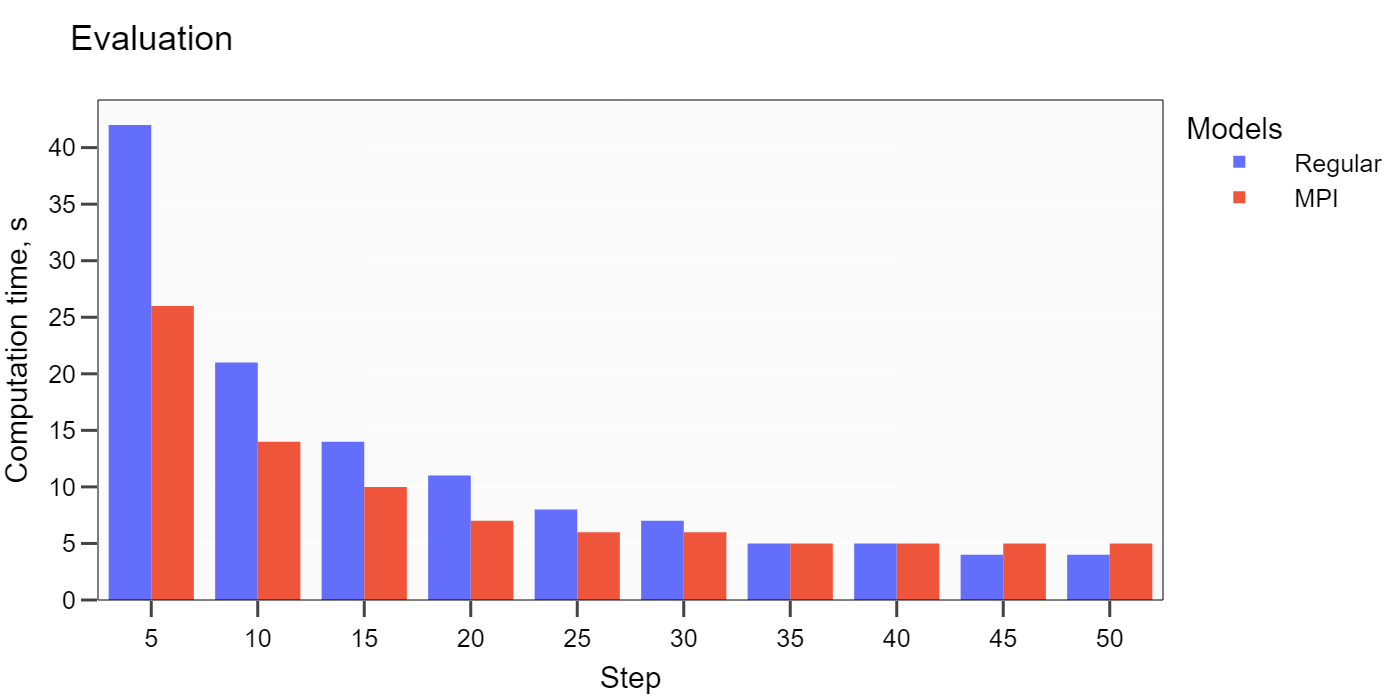

In [139]:
Image(open("Project_images/GibbsEnergy_evaluation.png", 'rb').read())

### Task 4: Helmholtz Free Energy

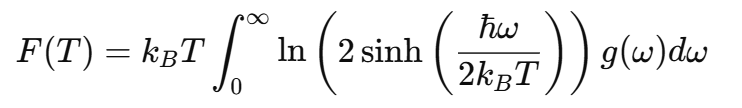

In [ ]:
def trapezoidal_function(f, xmin: int, xmax: float, n: int, **kwargs):
    integral = 0.0
    dx = (xmax - xmin) / (n+1)

    for x in np.linspace(xmin, xmax, n):
        integral += dx * ( f(x, **kwargs) + f(x+dx, **kwargs) )/2
    
    return integral
    
def helmholtz_energy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return np.log(2 * np.sinh(x / 2)) * 1 * omega**2 * np.exp(-omega / 10)

def gpu_helmholtz_energy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return cp.log(2 * cp.sinh(x / 2)) * 1 * omega**2 * cp.exp(-omega / 10)

def gpu_trapezoidal_function(f, xmin: int, xmax: float, n: int, **kwargs):
    integral = 0.0
    dx = (xmax - xmin) / (n+1)
    x = cp.linspace(xmin, xmax, n)

    integral = dx * ( f(x, **kwargs) + f(x+dx, **kwargs) )/2
    
    return integral.sum()

In [ ]:
Helm_energy_value = trapezoidal_function(
    f=helmholtz_energy,
    xmin=omega_min,
    xmax=omega_max,
    n=n,
    T=T,
    kb=kB,
    hbar=hbar
)
Helm_energy_value

In [ ]:
GPU_Helm_energy_value = gpu_trapezoidal_function(
    f=gpu_helmholtz_energy,
    xmin=omega_min,
    xmax=omega_max,
    n=n,
    T=T,
    kb=kB,
    hbar=hbar
)
GPU_Helm_energy_value